2024-04-05 23:33:28.434 | INFO     | FinMind.data.finmind_api:get_data:123 - download TaiwanStockInfo, data_id: 


0050
0050_元大台灣50 3990
0051
0051_元大中型100 3990
0053
0053_元大電子 3990
0054
0054_元大台商50 3562
0055
0055_元大MSCI金融 3990
0056
0056_元大高股息 3990
0061
0061_元大寶滬深 3594
006203
006203_元大MSCI台灣 3167
006206
006206_元大上證50 2911
00646
00646_元大S&P500 2023
00660
00660_元大歐洲50 1905
00661
00661_元大日經225 1901
00713
00713_元大台灣高息低波 1588
00739
00739_元大MSCI A股 1409
00762
00762_元大全球AI 1261


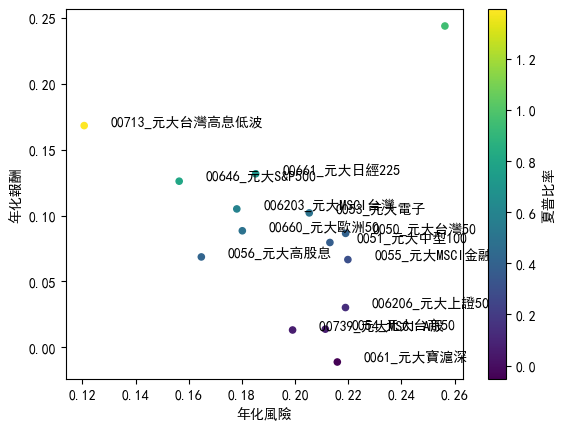

In [1]:
"""
(台灣)多金融商品比較
1. 取得台灣商品
2. 計算報酬、風險
3. 繪製在點圖上 X軸為風險 Y軸為報酬
"""

# 載入函數工具檔
from Data import getDataFM, getMultipleReturn
import pandas as pd
from FinMind.data import DataLoader
import matplotlib.pyplot as plt

plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False
api = DataLoader()

# 取出台灣元大投信的股票市場ETF
df = api.taiwan_stock_info()
ETF_dataframe = df[
    (df["industry_category"].str[:3] == "ETF")
    & (df["stock_name"].str.contains("元大"))
    & (df["stock_id"].str[-1].str.isnumeric())
]
stock_symbols = ETF_dataframe["stock_id"].to_list()

# 抓到所有歷史報酬率
ret_dataframe = getMultipleReturn(getDataFM, stock_symbols, "adj close")

# 風險報酬計算
rs = []
for col in ret_dataframe.columns:
    returns = ret_dataframe[col].dropna()
    if (returns.count() / 252) > 5:
        symbol_name = ETF_dataframe.loc[
            ETF_dataframe["stock_id"] == col, "stock_name"
        ].iloc[0]
        print(col)
        # 計算年化報酬率 年化標準差
        ann_ret = (returns).prod() ** (252 / returns.count()) - 1
        ann_risk = (returns - 1).std() * (252**0.5)
        ann_sharp = ann_ret / ann_risk
        print(f"{col}_{symbol_name}", returns.count())
        rs.append([f"{col}_{symbol_name}", ann_ret, ann_risk, ann_sharp])
# 每檔商品的風險報酬
rsdf = pd.DataFrame(rs)
rsdf.columns = ["名稱", "年化報酬", "年化風險", "夏普比率"]
rsdf.set_index("名稱", inplace=True)

ax = rsdf.plot.scatter(x="年化風險", y="年化報酬", c="夏普比率", colormap="viridis")

for i, txt in enumerate(rsdf.transpose()):
    ax.annotate(txt, (rsdf["年化風險"].iat[i] + 0.01, rsdf["年化報酬"].iat[i]))
